<a href="https://colab.research.google.com/github/natkor18/Data_Science_yandex_project/blob/main/tree/main/cost-of-the-car/pri%D1%81e_auto_prediction_on_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.



**Описание данных**

**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
- Price — цена (евро)



## Подготовка данных

In [ ]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#Все подключаемые библиотеки вначале в одной ячейке
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from sklearn.compose import make_column_transformer
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, make_scorer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.datasets import make_regression
from lightgbm import LGBMRegressor
import time as t
from sklearn.pipeline import make_pipeline, Pipeline
from catboost import Pool, CatBoostRegressor, cv
import warnings
from sklearn.preprocessing import LabelBinarizer

warnings.filterwarnings("ignore")


Считаем данные и выведем первые строки. Посмотрим, какие есть значения, как выглядят признаки.

In [ ]:
data = pd.read_csv("/datasets/autos.csv")

In [ ]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
data.shape

(354369, 16)

Выведем информацию о данных

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Оценим пропуски в данных.

In [ ]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Посмотрим на уникальные значения в признаках, возможно имеются неявные дубликаты

In [ ]:
lst = ['VehicleType', 'Gearbox','Model','FuelType','Repaired','Brand']
for item in lst:
    print(item,': ' , sorted(','.join(str(i) for i in data[item].unique()).split(',')))
    print()

VehicleType :  ['bus', 'convertible', 'coupe', 'nan', 'other', 'sedan', 'small', 'suv', 'wagon']

Gearbox :  ['auto', 'manual', 'nan']

Model :  ['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klass

Так как будем заполнять пропуски значением "other", стоит посчитать, а сколько таких значений уже есть в данных признаках.

In [ ]:
def count_del(lst):
    for item in lst:
        print(f"{item}: {len(data.loc[data[item] == 'other'])}")

In [ ]:
count_del(['Model','VehicleType','FuelType','Gearbox', 'Repaired'])

Model: 24421
VehicleType: 3288
FuelType: 204
Gearbox: 0
Repaired: 0


Такие значения уже есть, вероятно их количество увеличится.  Проверим на наличие явных дубликатов

In [ ]:
data.duplicated().sum()

4

Найдем эти дубли

In [ ]:
data[data.duplicated()].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Удаление дубликатов будет выполнено позже, если они останутся.


Датасет содержит 354365 строк по 16 столбцов.

**Есть пропуски в данных:**
- VehicleType (тип автомобильного кузова) - 37490 примерно 10%
- Gearbox  (тип коробки передач) - 19833 - 5%
- Model (модель автомобиля) - 19705 - 5%
- FuelType (тип топлива) - 32895 - 10%
- Repaired (была машина в ремонте или нет) - 71154 - 20%

**Тип данных в столбцах**
- DateCrawled (дата скачивания анкеты из базы)    
- DateCreated (дата создания анкеты)
строковый, возможно преобразовать к типу дата или создать новые столбцы с датой

Тип данных - Repaired (была машина в ремонте или нет) - строковый, имеет смысл преобразовать к логическому типу данных: 1 - была в ремонтке, 0 - не была в ремонте.

Неявных дубликатов не обнаружено. Явных дубликатов - 4. Удалили их, обновили индексацию.

Стоит проверить данные на выбросы и аномалии. Посмотриеть нужна ли стандартизация данных.


**Займемся пропусками**

Попробуем удалить все пропуски, посмотрим какая это часть от общего объема данных


Попробуем все пропуски преобразовать в other.

Заполним пропущенные данные:
- Model - заменим модой с группировкой по бренду и году регистрации
- Repaired - other
- "VehicleType", "FuelType", "Gearbox" - модой с группировкой по модели автомобиля году регистрации


In [ ]:
data['Repaired'].fillna('other', inplace = True)

In [ ]:
def fill_mode(col1, col2, val):
    data[val] = data.groupby([col1, col2])[val].transform(lambda x: x.mode()[0] if not x.mode().empty else "other")

In [ ]:
fill_mode('Brand','RegistrationYear', 'Model')
fill_mode('Model','RegistrationYear', 'VehicleType')
fill_mode('Model','RegistrationYear', 'FuelType')
fill_mode('Model','RegistrationYear', 'Gearbox')

In [ ]:
count_del(['Model','VehicleType','FuelType','Gearbox', 'Repaired'])

Model: 24109
VehicleType: 6317
FuelType: 133
Gearbox: 130
Repaired: 71154


In [ ]:
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Для признаков «VehicleType», «FuelType» пропущенные значения можно заменить модой с группировкой по модели автомобиля и году регистрации - то есть самым часто встречающимся значением для конкретной модели, зарегистрированной в конкретный год. То же самое можно отнести к признаку «Gearbox», у него не очень высокий процент пропущенных значений.


In [ ]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,other,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,wagon,2011,manual,190,a4,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,other,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,wagon,2008,manual,69,octavia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
data.shape

(354369, 16)

На данном этапе сохранены все пропущенные данные, да к тому же и заполнены. Интересно, как это повлияет на выбросы.

Признаки PostalCode (почтовый индекс владельца анкеты (пользователя)), DateCreated (дата создания анкеты), LastSeen (дата последней активности пользователя) являются несущественными с точки зрения прогноза стоимости автомобиля, поэтому удалим их.

Также стоит посмотреть уникальные начения признака "Количество фотографий".


In [ ]:
data['NumberOfPictures'].unique()

array([0])

Все значения в столбце о количесвте фотографий - 0, незначимый признак, его также удалим

In [ ]:
data = data.drop(['PostalCode','LastSeen','NumberOfPictures'], axis="columns")

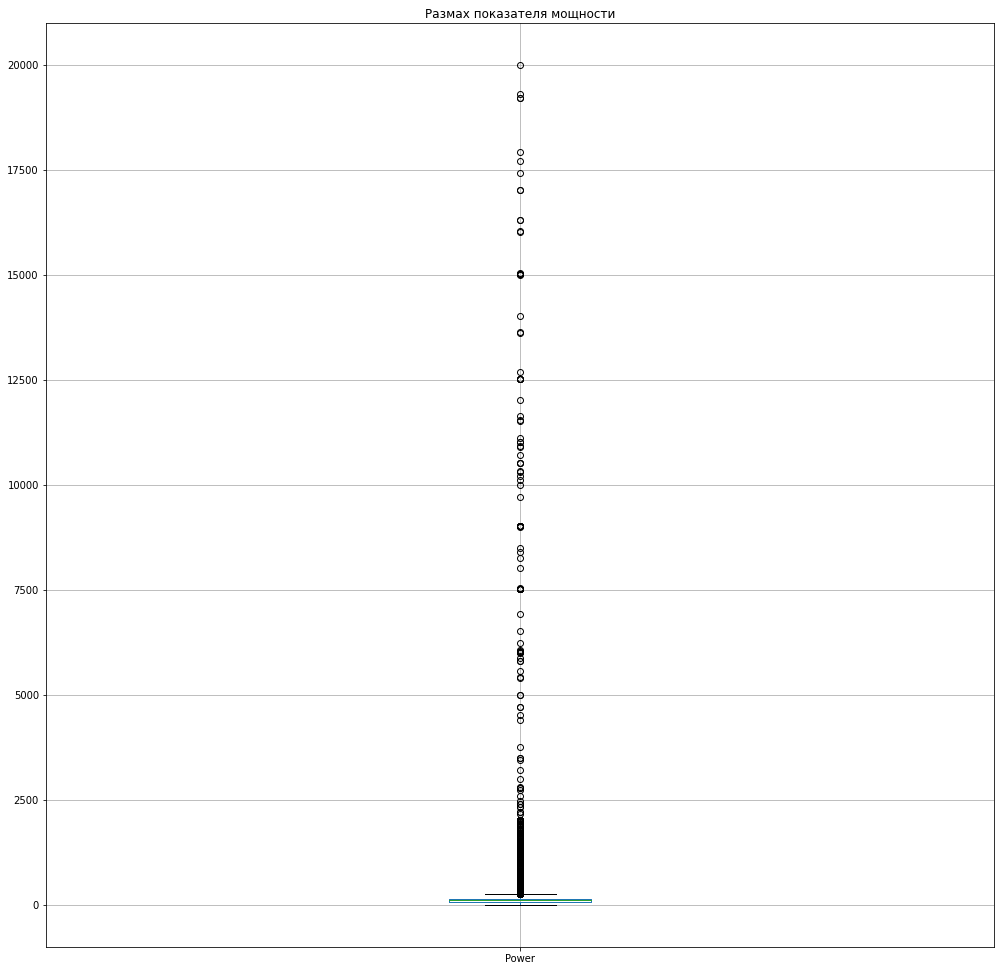

In [ ]:
data['Power'].plot(kind='box', title='Размах показателя мощности', figsize=(17,17), grid=True);

In [ ]:
print(sorted(data['Power'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

<b>Поработаем с выбросами</b>

Есть нули и аномально низкие значения.
Можно оставить нижнюю границу 9, полагая, что автомобили с меньшей мощностью относятся скорее всего к "ретро" и помня о том, что основное количество объявлений о продаже автомобилей в 2000-х годах. Можно наверное до 13 было бы удалить.
    

Верхняя граница. Посмотрим данные. Видно, что выше 1000 л.с. - однозначно - неверные ззначения. Их удалять - это 302 записи. А потом можно еще посмотреть данные в диапазоне от 250 до 1000. Может оставить верхнюю границу в 500.  


In [ ]:
print('Всего автомобилей мощностью больше 1000:', len(data.loc[data['Power'] >1000]))

Всего автомобилей мощностью больше 1000: 302


In [ ]:
print(data.loc[data['Power']>1000, ['Power','Brand', 'Model']].sort_values(by='Power', ascending=False))

        Power          Brand     Model
219584  20000  mercedes_benz  a_klasse
299180  19312            bmw       3er
114106  19211            bmw       3er
132485  19208            bmw       3er
63986   17932           opel     corsa
...       ...            ...       ...
79305    1001  mercedes_benz  c_klasse
179821   1001           audi        a4
307044   1001           opel     astra
351947   1001           opel     corsa
5328     1001           opel     astra

[302 rows x 3 columns]


In [ ]:
data.drop(index=data.query('Power>1000').index,inplace=True)

In [ ]:
print('Всего автомобилей мощностью менее 9:', len(data.loc[data['Power'] <9]))

Всего автомобилей мощностью менее 9: 40440


40440- автомобилей с мощностью меньше 9. Удалим эти записи.

In [ ]:
data.drop(index=data.query('Power <9').index,inplace=True)

In [ ]:
print(data.loc[data['Power']>500, ['Power','Brand', 'Model']].sort_values(by='Power', ascending=False))

        Power           Brand  Model
174893   1000      volkswagen   golf
125086   1000             bmw    3er
348830   1000  sonstige_autos  other
209422   1000      volkswagen   golf
119442   1000             bmw    3er
...       ...             ...    ...
91326     507             bmw    3er
177451    505            audi     a4
221255    504            audi     a3
124994    504            audi     a4
23188     504            audi     a4

[157 rows x 3 columns]


In [ ]:
data.drop(index=data.query('Power >500').index,inplace=True)

Видим, мощности все-таки неправдоподобные в рамках этих брендов+ модель. Поэтому можно еще удалить. Оставлю верхнюю границу в 500.
   

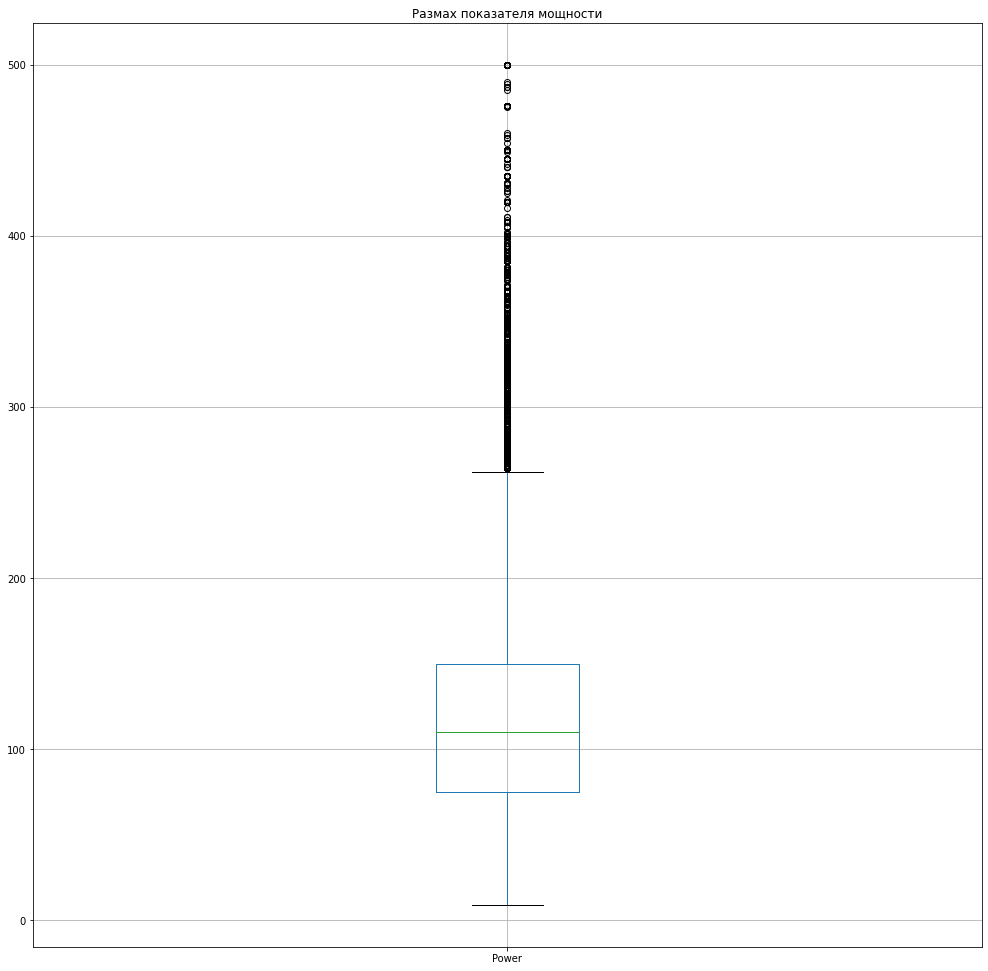

In [ ]:
data['Power'].plot(kind='box', title='Размах показателя мощности', figsize=(17,17), grid=True);

In [ ]:
print("Всего объявлений с ценой равной 0:", len(data.loc[data['Price'] == 0]))

Всего объявлений с ценой равной 0: 6866


In [ ]:
data.drop(index=data.query('Price == 0').index,inplace=True)

In [ ]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated
1,2016-03-24 10:58:45,18300,wagon,2011,manual,190,a4,125000,5,gasoline,audi,yes,2016-03-24 00:00:00
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,other,2016-03-14 00:00:00
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00
4,2016-03-31 17:25:20,3600,wagon,2008,manual,69,octavia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00


In [ ]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,306604.000000,306604.000000,306604.000000,306604.000000,306604.000000
mean,4810.652115,2003.518561,120.190767,128461.321444,5.963366
std,4585.900428,32.618865,53.390745,36690.685887,3.599893
min,1.000000,1000.000000,9.000000,5000.000000,0.000000
25%,1300.000000,1999.000000,75.000000,125000.000000,3.000000
50%,3100.000000,2003.000000,110.000000,150000.000000,6.000000
75%,6950.000000,2008.000000,150.000000,150000.000000,9.000000
max,20000.000000,9999.000000,500.000000,150000.000000,12.000000


In [ ]:
print(', '.join(sorted(data['Brand'].unique())))

alfa_romeo, audi, bmw, chevrolet, chrysler, citroen, dacia, daewoo, daihatsu, fiat, ford, honda, hyundai, jaguar, jeep, kia, lada, lancia, land_rover, mazda, mercedes_benz, mini, mitsubishi, nissan, opel, peugeot, porsche, renault, rover, saab, seat, skoda, smart, sonstige_autos, subaru, suzuki, toyota, trabant, volkswagen, volvo


In [ ]:
x = sorted(data['Model'].unique())
y = data.groupby('Model')['Repaired'].count()
z1 = data.groupby('Model')['Repaired'].apply(lambda x: (x=='yes').sum())
z2 = data.groupby('Model')['Repaired'].apply(lambda x: (x=='no').sum())
z3 = data.groupby('Model')['Repaired'].apply(lambda x: (x=='other').sum())


data_model = pd.DataFrame(data=zip(x,y,z1,z2,z3), columns=['Модель','Кол-во','Ремонт был (кол-во)',\
                                                           'Ремонт не был (кол-во)','Неизвестно'])
data_model['% соотн был ремонт'] =  round((data_model['Ремонт был (кол-во)'] /data_model['Кол-во'])*100,2)
data_model['% соотн ремонт не был'] =  round((data_model['Ремонт не был (кол-во)'] /data_model['Кол-во'])*100,2)

data_model

,Модель,Кол-во,Ремонт был (кол-во),Ремонт не был (кол-во),Неизвестно,% соотн был ремонт,% соотн ремонт не был
0,100,14,0,11,3,0.00,78.57
1,147,494,80,317,97,16.19,64.17
2,156,812,134,562,116,16.50,69.21
3,159,334,29,288,17,8.68,86.23
4,1_reihe,935,139,594,202,14.87,63.53
...,...,...,...,...,...,...,...
131,wrangler,56,6,38,12,10.71,67.86
132,x_type,177,25,125,27,14.12,70.62
133,xc_reihe,306,9,291,6,2.94,95.10
134,yaris,2581,175,2162,244,6.78,83.77


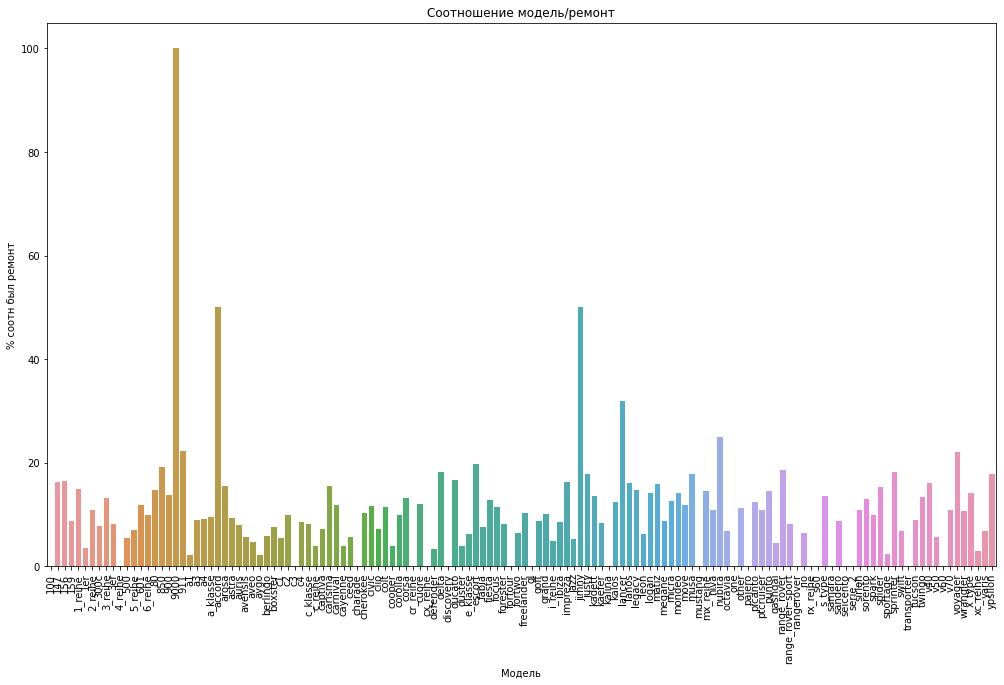

In [ ]:
plt.figure(figsize = (17, 10))
ax = sns.barplot(data=data_model, x = data_model['Модель'], \
                 y = data_model['% соотн был ремонт']).set_title('Соотношение модель/ремонт');
plt.xticks(rotation=90);

In [ ]:
data_model.sort_values(by='% соотн был ремонт')[:20]

,Модель,Кол-во,Ремонт был (кол-во),Ремонт не был (кол-во),Неизвестно,% соотн был ремонт,% соотн ремонт не был
0,100,14,0,11,3,0.0,78.57
44,charade,4,0,3,1,0.0,75.00
52,cr_reihe,3,0,2,1,0.0,66.67
54,cx_reihe,1,0,1,0,0.0,100.00
35,c3,26,0,25,1,0.0,96.15
57,discovery,34,0,30,4,0.0,88.24
66,forfour,3,0,2,1,0.0,66.67
69,gl,1,0,1,0,0.0,100.00
93,mustang,19,0,14,5,0.0,73.68
98,one,31,0,30,1,0.0,96.77


In [ ]:
data_model.sort_values(by='% соотн был ремонт', ascending=False)[:20]

,Модель,Кол-во,Ремонт был (кол-во),Ремонт не был (кол-во),Неизвестно,% соотн был ремонт,% соотн ремонт не был
18,9000,7,7,0,0,100.00,0.00
76,jimny,2,1,1,0,50.00,50.00
24,accord,2,1,1,0,50.00,50.00
82,lancer,22,7,10,5,31.82,45.45
96,nubira,36,9,21,6,25.00,58.33
19,911,9,2,3,4,22.22,33.33
130,voyager,259,57,156,46,22.01,60.23
61,escort,285,56,166,63,19.65,58.25
16,850,265,51,178,36,19.25,67.17
105,range_rover,43,8,30,5,18.60,69.77


In [ ]:
x = sorted(data['Brand'].unique())
y = data.groupby('Brand')['Repaired'].count()
z = data.groupby('Brand')['Repaired'].apply(lambda x: (x=='yes').sum())

data_brand = pd.DataFrame(data=zip(x,y,z), columns=['Brand','Кол-во','Ремонт'])
data_brand['Procent'] =  round((data_brand['Ремонт'] /data_brand['Кол-во'])*100,2)


data_brand.sort_values(by='Procent')[:20]

,Brand,Кол-во,Ремонт,Procent
21,mini,3054,121,3.96
32,smart,4610,292,6.33
36,toyota,4119,293,7.11
26,porsche,625,45,7.20
31,skoda,5055,367,7.26
6,dacia,823,64,7.78
20,mercedes_benz,28020,2204,7.87
2,bmw,33081,2633,7.96
33,sonstige_autos,1763,153,8.68
38,volkswagen,66938,5837,8.72


In [ ]:
data_brand.sort_values(by='Procent', ascending=False)[:20]

,Brand,Кол-во,Ремонт,Procent
28,rover,386,79,20.47
7,daewoo,427,75,17.56
17,lancia,397,65,16.37
34,subaru,663,94,14.18
4,chrysler,1195,168,14.06
29,saab,485,67,13.81
22,mitsubishi,2580,354,13.72
0,alfa_romeo,2041,276,13.52
9,fiat,7975,991,12.43
8,daihatsu,636,78,12.26


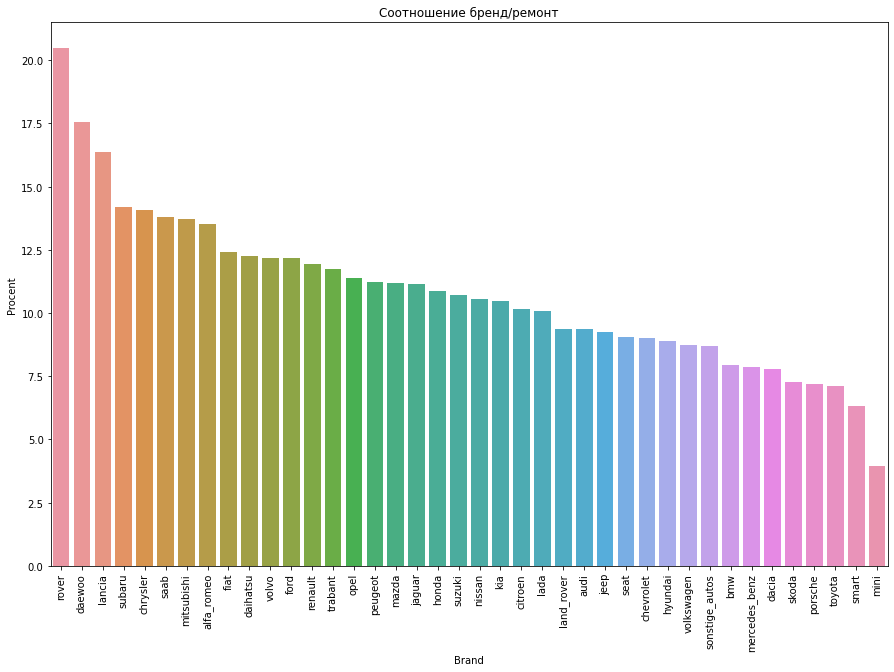

In [ ]:
plt.figure(figsize = (15, 10))
ax = sns.barplot(data=data_brand, x = data_brand['Brand'], y = data_brand['Procent'], \
                 order=data_brand.sort_values('Procent', ascending=False).Brand).set_title('Соотношение бренд/ремонт');
plt.xticks(rotation=90);

In [ ]:
# Удалим дубликаты
data= data.drop_duplicates().reset_index(drop=True)

In [ ]:
data.duplicated().sum()

0

<div class="alert alert-block alert-info">
Объединим вид топлива 'petrol' и 'gasoline'. Это оказывается одно название бензина.
</div>


In [ ]:
data.loc[(data.FuelType=='gasoline'), 'FuelType'] = 'petrol'
data['FuelType'].unique()

array(['petrol', 'lpg', 'other', 'cng'], dtype=object)

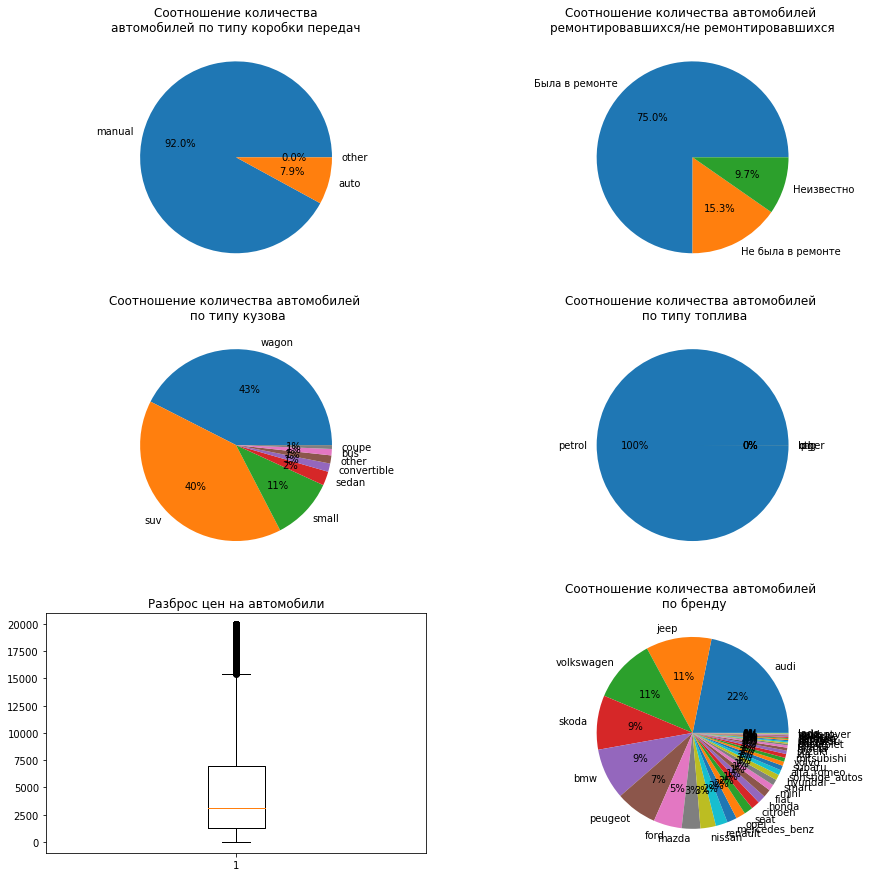

In [ ]:
figure, axis = plt.subplots(3, 2, figsize=(15, 15))

axis[0,0].pie(data['Gearbox'].value_counts(), labels=data['Gearbox'].unique(),autopct='%1.1f%%');
axis[0,0].set_title("Соотношение количества\nавтомобилей по типу коробки передач")


axis[0,1].pie(data['Repaired'].value_counts(), labels=['Была в ремонте','Не была в ремонте', 'Неизвестно'], autopct='%1.1f%%')
axis[0,1].set_title("Соотношение количества автомобилей \nремонтировавшихся/не ремонтировавшихся");


lst=data['VehicleType'].unique()
axis[1,0].pie(data['VehicleType'].value_counts(), labels=lst, autopct='%1.0f%%');
axis[1,0].set_title("Соотношение количества автомобилей \n по типу кузова")

lst_FuelType=data['FuelType'].unique()
axis[1,1].pie(data['FuelType'].value_counts(), labels=lst_FuelType, autopct='%1.0f%%');
axis[1,1].set_title("Соотношение количества автомобилей \n по типу топлива");

axis[2,0].boxplot(data['Price'])
axis[2,0].set_title("Разброс цен на автомобили");


lst_brand = data['Brand'].unique()
axis[2,1].pie(data['Brand'].value_counts(), labels=lst_brand,autopct='%1.0f%%');
axis[2,1].set_title("Соотношение количества автомобилей \n по бренду");



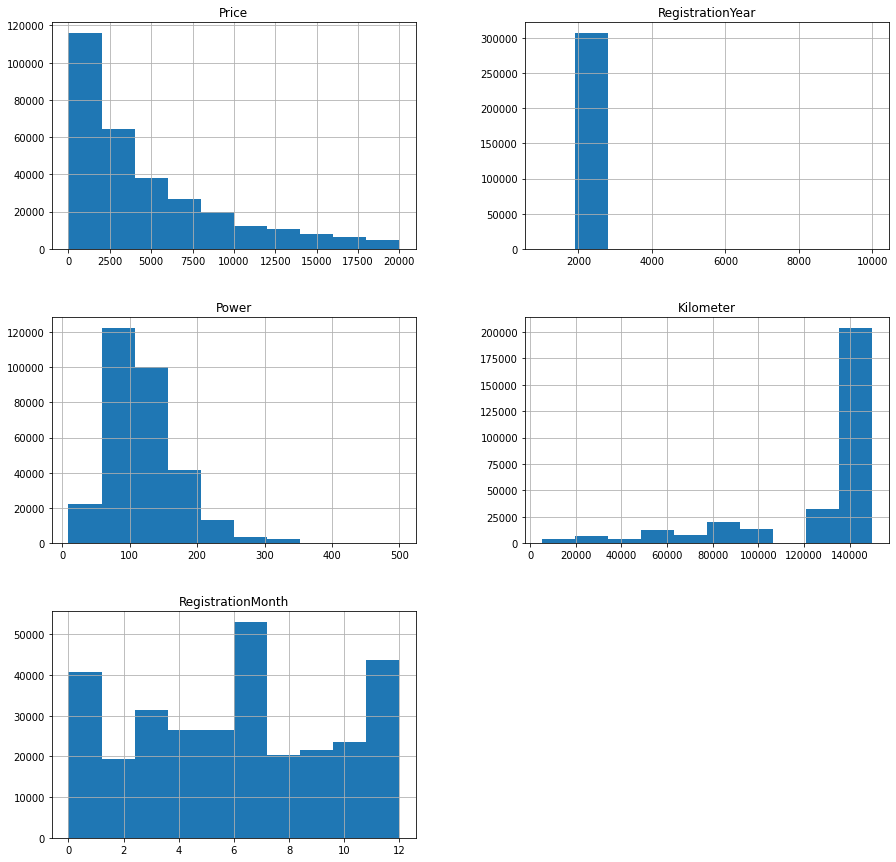

In [ ]:
data.hist(figsize=(15,15));

In [ ]:
print(sorted(data['RegistrationYear'].unique()))

[1000, 1234, 1500, 1800, 1910, 1923, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2800, 2900, 3000, 4000, 4500, 5000, 5911, 6000, 6500, 8000, 8200, 9999]


<div class="alert alert-block alert-info">
Появились данные со странными значениями годов. Удалим все данные ранее 1910 и позднее 2019. Потом посмотрим еще раз

</div>

In [ ]:
data.drop(index=data.query('RegistrationYear<1910').index,inplace=True)
data.drop(index=data.query('RegistrationYear>2019').index,inplace=True)


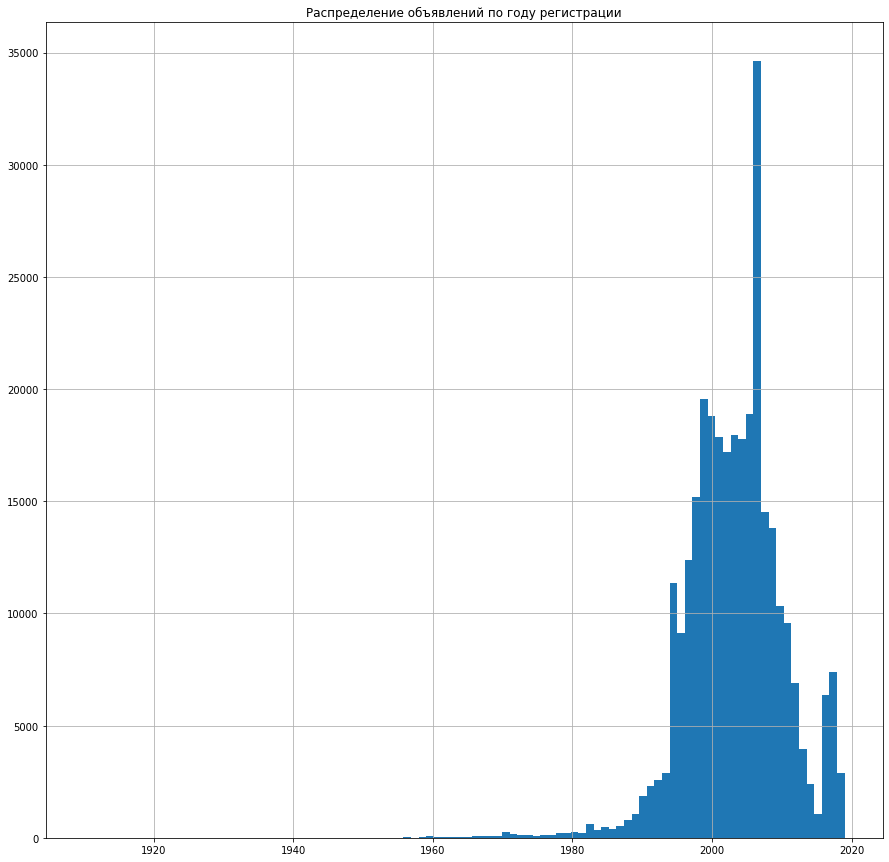

In [ ]:
data['RegistrationYear'].hist(figsize=(15,15), bins=100).set_title("Распределение объявлений по году регистрации");

In [ ]:
def year_plot(res):
    plt.figure(figsize=(15,10))
    plt.title("Количество объявлений о продаже автомобилей по году регистрации", fontsize=15);
    plt.plot(res, 'o-', label='RegistrationYear', alpha=1);
    plt.xlabel("Год регистрации")
    plt.ylabel("Количество объявлений о продаже")
    plt.grid(True);
    plt.legend();

RegistrationYear
1910       6
1923       1
1927       1
1928       1
1929       4
        ... 
2015    1065
2016    6369
2017    7392
2018    2871
2019      10
Name: DateCrawled, Length: 92, dtype: int64


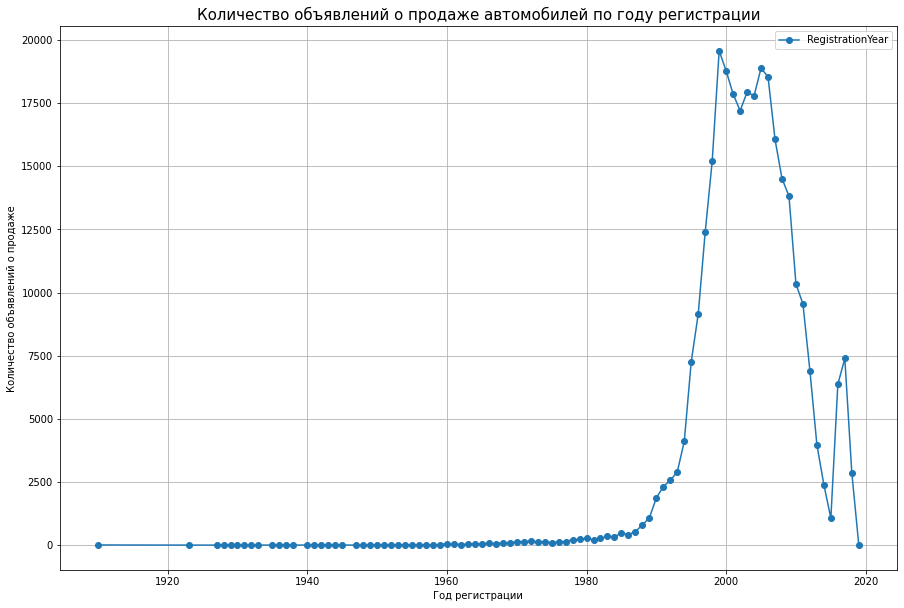

In [ ]:
res = data.groupby('RegistrationYear')['DateCrawled'].count()
print(res)
year_plot(res)

Все что ранее 1980 года можно удалить.

In [ ]:
data.drop(index=data.query('RegistrationYear<1980').index,inplace=True)

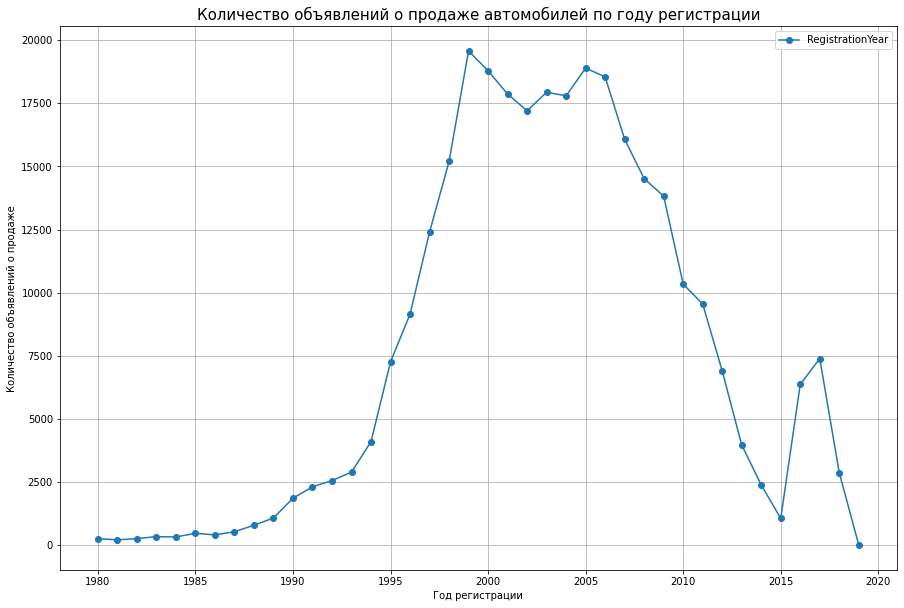

In [ ]:
res = data.groupby('RegistrationYear')['DateCrawled'].count()
year_plot(res)

В ходе исследования выяснилось:
    
- на "механике", это около 92%, "автомат" - около 7,9%,
    
- почти 75% машин из опубликованных объявлений были в ремонте, не ремонтировались 15%, остальные - неизвестно.
- практически все автомобили на бензине.
- популярные типы кузова: wagon - 43%, suv - 40%, small - 11%
- самый популярный бренд - audi - 22%, jeep - 11%, volkswagen - 11%, skoda - 9%, bmw - 9%, peugeot- 7%, ford - 5%.
- стоимость автомобиля около 4000 евро, наблюдаются аномалии как в большую, так и в меньшую стороны. В целом диапазон цен в интервале от 1500 евро до 7500.

- большая часть объявлений - это автомобили 2002 года регистрации
- больше объявлений на продажу автомобилей, уже имеющих пробег, в основном - в районе 100_000 (даже больше 140_000)
- большая часть объявлений - это автомобили 2000-х годов регистрации.

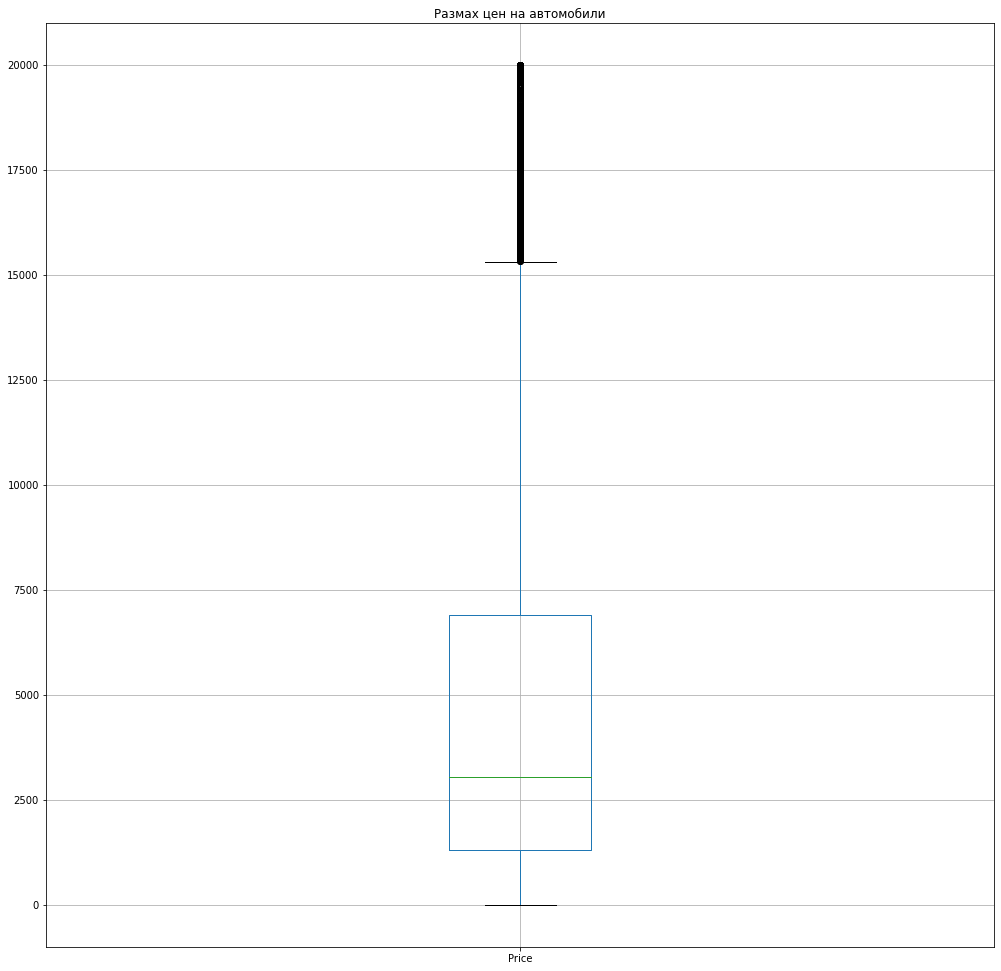

In [ ]:
data['Price'].plot(kind='box', title='Размах цен на автомобили', figsize=(17,17), grid=True);

Наблюдаются выбросы. Проверим количество автомобилей по цене близкой к нулу и проверим количество автомобилей по цене выше верхнего уса.

In [ ]:
print('Всего автомобилей стоимостью менее 100 но больше 0 евро:',data.query('Price < 100 and Price >0')['Price'].count(), \
      "\nГоды:", sorted(data.query('Price >0 and Price <100')['RegistrationYear'].unique() ))
print()
print('Всего автомобилей стоимостью от 100 до 7500 евро:',data.query('Price >0 and Price <7500')['Price'].count(), \
      "\nГоды:", sorted(data.query('Price >100 and Price <7500')['RegistrationYear'].unique()))
print()
print('Всего автомобилей стоимостью от 7500 до 16000 евро:',data.query('Price >7500 and Price <16000')['Price'].count(),\
      "\nГоды:", sorted(data.query('Price >100 and Price <7500')['RegistrationYear'].unique()))
print()
print('Всего автомобилей стоимостью более 15000 евро:',data.query('Price > 15000')['Price'].count(),\
      "\nГоды:", sorted(data.query('Price >16000')['RegistrationYear'].unique()))



Всего автомобилей стоимостью менее 100 но больше 0 евро: 1208 
Годы: [1980, 1981, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

Всего автомобилей стоимостью от 100 до 7500 евро: 235603 
Годы: [1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

Всего автомобилей стоимостью от 7500 до 16000 евро: 56069 
Годы: [1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

Всего автомобилей стоимостью более 15000 евро: 14118 
Годы: [1980, 1981, 1982, 1983, 1984, 198

<!-- Удалим данные, стоимость которых выше 15000.  -->

In [ ]:
data.drop(index=data.query('Price > 15_000').index, inplace=True)

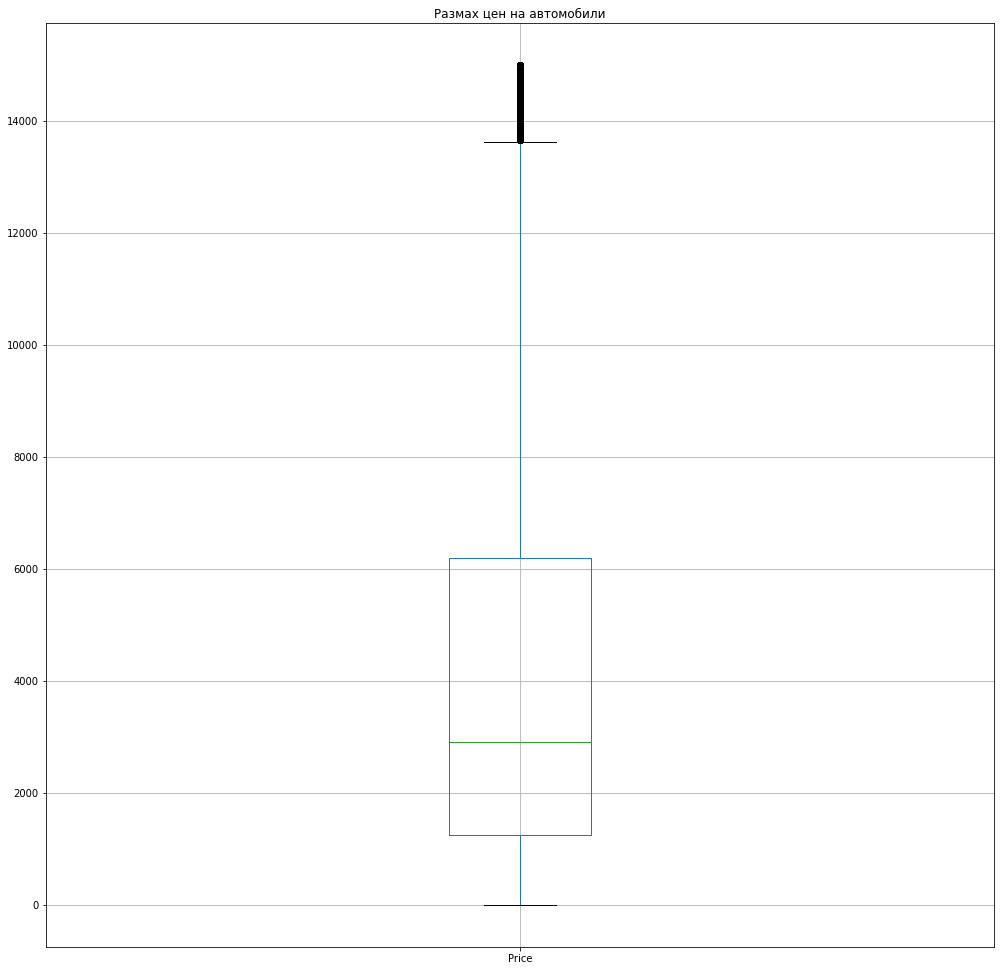

In [ ]:
data['Price'].plot(kind='box', title='Размах цен на автомобили', figsize=(17,17), grid=True);

Проверим как признаки коррелируют со стоимостью автомобилей

In [ ]:
line_list = ['RegistrationYear', 'Power','Kilometer','RegistrationMonth']

for param in line_list:
    correlation = data['Price'].corr(data[param])
    print(f'Корреляция между стоимостью автомобиля и {param} составляет: {correlation:0.2%}')

Корреляция между стоимостью автомобиля и RegistrationYear составляет: 47.47%
Корреляция между стоимостью автомобиля и Power составляет: 47.58%
Корреляция между стоимостью автомобиля и Kilometer составляет: -33.57%
Корреляция между стоимостью автомобиля и RegistrationMonth составляет: 7.86%


<div class="alert alert-block alert-info">
Добавим красивую тепловую карту и таблицу корреляции
    
</div>

,RegistrationYear,Power,Kilometer,RegistrationMonth,Price
RegistrationYear,1.000000,0.072603,-0.282378,0.017529,0.474727
Power,0.072603,1.000000,0.143385,0.041786,0.475838
Kilometer,-0.282378,0.143385,1.000000,-0.015893,-0.335686
RegistrationMonth,0.017529,0.041786,-0.015893,1.000000,0.078649
Price,0.474727,0.475838,-0.335686,0.078649,1.000000


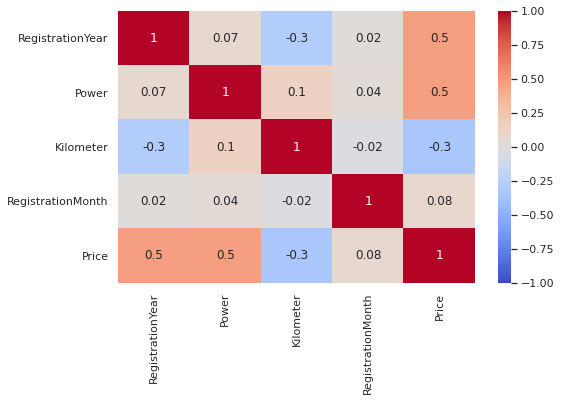

In [ ]:
data_cor = data[['RegistrationYear', 'Power','Kilometer','RegistrationMonth','Price']].copy()
sns.set(rc = {'figure.figsize':(8,5)})
sns.heatmap(data_cor.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm');
data_cor.corr()

<div class="alert alert-block alert-info">
Теперь несколько изменились коррелирующие признаки. Произошло смещение в сторону мощности. Получилось, что мощность сильнее всего коррелирует со стоимостью, а год регистрации - занимает второе место. Такое изменение произошло после того, как увеличилась верхняя граница мощности в оставленных объявлениях. Раньше оставляла - 250, сейчас - 500.
</div>

Налицо прямая корреляция между стоимостью и годом регистрации автомобиля. Чем "свежее" машина, тем стоимость выше, наблюдаем обратную сильную корреляцию с пробегом, что логично. Чем больше пробег, тем стоиомсть ниже. Есть также щзависимость между мощностью и ценой. И, что также прогнозируемо низкая корреляция между месяцем регистрации и стоиомстью.

Однако стоит проверить, цены на автомобили, раньше какого-то года.


Проведем стандартизацию категориальных признаков. Затем выполним масштабирование.


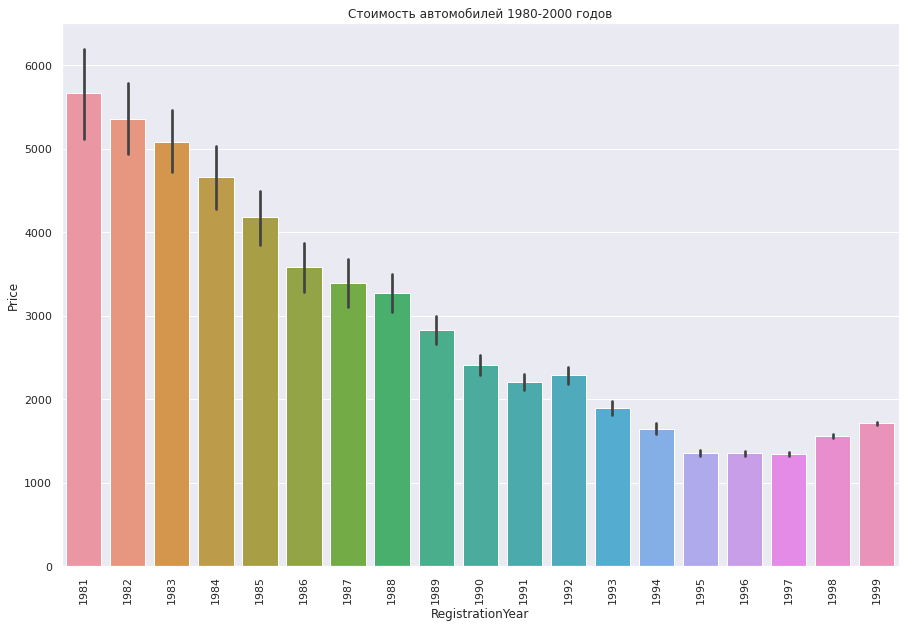

In [ ]:
x = data.query('RegistrationYear > 1980 and RegistrationYear<2000')['RegistrationYear']

plt.figure(figsize = (15, 10))
sns.barplot(data=data, x = x, y = data['Price']).set_title("Стоимость автомобилей 1980-2000 годов");
plt.xticks(rotation=90);

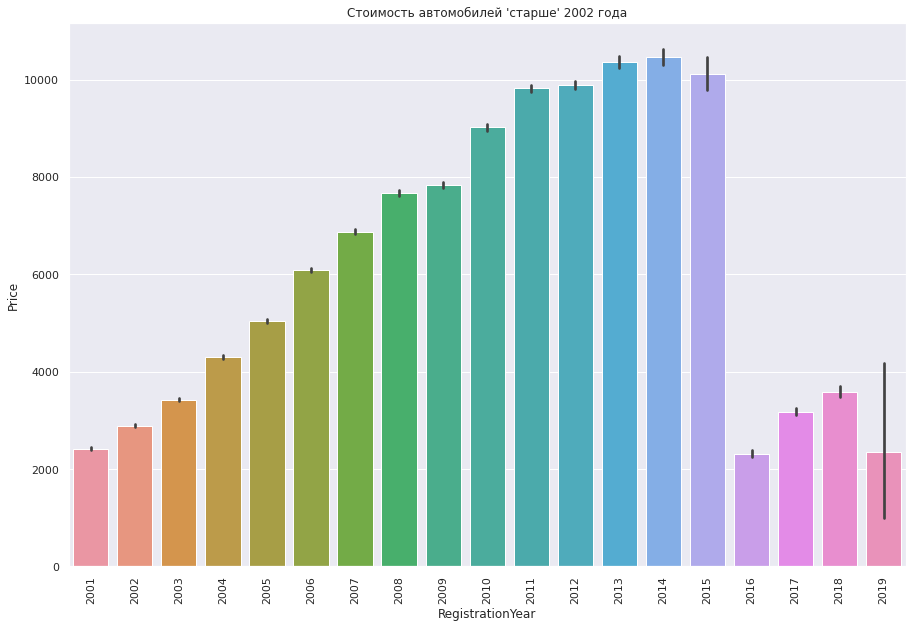

In [ ]:
x = data.query('RegistrationYear > 2000')['RegistrationYear']

plt.figure(figsize = (15, 10))
sns.barplot(data=data, x = x, y = data['Price']).set_title("Стоимость автомобилей 'старше' 2002 года");
plt.xticks(rotation=90);

В датасете остались категориальные данные, которые являются значимыми и могут оказывать существенно влияние на целевой признак - стоимость автомобиля. К таким категориальным признакам относятся:
- VehicleType
- Gearbox
- Model
- FuelType
- Brand
Преобразуем их в численные, техникой прямого кодирования. Она работает со всеми моделями.

In [ ]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated
1,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,other,2016-03-14 00:00:00
2,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00
3,2016-03-31 17:25:20,3600,wagon,2008,manual,69,octavia,90000,7,petrol,skoda,no,2016-03-31 00:00:00
4,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00
5,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00


Проверим, есть ли в датасете такие данные, что дата скачивания анкеты или дата создания анкеты пользователя старше чем год регистрации автомобиля. Это также вероятно ошибочные данные. Их можно будет тоже удалить.

Сначала преобразуем данные из 'DateCrawled','DateCreated'. В новые столбцы запишем годы создания объявления и скачивания анкеты.
Столбцы 'DateCrawled','DateCreated' после этого удалим.

In [ ]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
data['DateCreated'] = pd.to_datetime(data['DateCreated'])
data['YearDateCrawled'] = pd.DatetimeIndex(data['DateCrawled']).year
data['YearCreated'] = pd.DatetimeIndex(data['DateCreated']).year
data = data.drop(['DateCrawled','DateCreated'], axis="columns")
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,YearDateCrawled,YearCreated
1,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,other,2016,2016
2,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016,2016
3,3600,wagon,2008,manual,69,octavia,90000,7,petrol,skoda,no,2016,2016
4,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016,2016
5,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016,2016


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290228 entries, 1 to 306574
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              290228 non-null  int64 
 1   VehicleType        290228 non-null  object
 2   RegistrationYear   290228 non-null  int64 
 3   Gearbox            290228 non-null  object
 4   Power              290228 non-null  int64 
 5   Model              290228 non-null  object
 6   Kilometer          290228 non-null  int64 
 7   RegistrationMonth  290228 non-null  int64 
 8   FuelType           290228 non-null  object
 9   Brand              290228 non-null  object
 10  Repaired           290228 non-null  object
 11  YearDateCrawled    290228 non-null  int64 
 12  YearCreated        290228 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 39.1+ MB


In [ ]:
data_year = data.query('RegistrationYear > YearDateCrawled' or 'RegistrationYear > YearCreated').index
len(data_year)

10080

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290228 entries, 1 to 306574
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              290228 non-null  int64 
 1   VehicleType        290228 non-null  object
 2   RegistrationYear   290228 non-null  int64 
 3   Gearbox            290228 non-null  object
 4   Power              290228 non-null  int64 
 5   Model              290228 non-null  object
 6   Kilometer          290228 non-null  int64 
 7   RegistrationMonth  290228 non-null  int64 
 8   FuelType           290228 non-null  object
 9   Brand              290228 non-null  object
 10  Repaired           290228 non-null  object
 11  YearDateCrawled    290228 non-null  int64 
 12  YearCreated        290228 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 39.1+ MB


In [ ]:
data.drop(data_year, inplace=True)

In [ ]:
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,YearDateCrawled,YearCreated
1,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,other,2016,2016
2,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016,2016
3,3600,wagon,2008,manual,69,octavia,90000,7,petrol,skoda,no,2016,2016
4,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016,2016
5,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
306570,5250,sedan,2016,manual,150,147,150000,12,petrol,alfa_romeo,no,2016,2016
306571,3200,small,2004,manual,225,ibiza,150000,5,petrol,seat,yes,2016,2016
306572,1199,small,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016,2016
306573,9200,small,1996,manual,102,golf,150000,3,petrol,volkswagen,no,2016,2016


In [ ]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,YearDateCrawled,YearCreated
1,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,other,2016,2016
2,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016,2016
3,3600,wagon,2008,manual,69,octavia,90000,7,petrol,skoda,no,2016,2016
4,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016,2016
5,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016,2016


<div class="alert alert-block alert-info">
Можно  также теперь удалить признаки "YearDateCrawled","YearCreated", "RegistrationMonth" как незначащие.

</div>

In [ ]:
data = data.drop(['YearDateCrawled','YearCreated', 'RegistrationMonth'], axis="columns")

На этапе кодирования появились несостыковки в выборках. Поработаем над этим.


In [ ]:
data.loc[(data.Gearbox=='other'), 'Gearbox'] = 'manual'

In [ ]:
data['Gearbox'].unique()

array(['auto', 'manual'], dtype=object)

- Масштабирование
- нужна ли DateCrawled
- выбросы и аномалии
- графики
- первые закономерности
- посчитать и построить корреляцию по цене и другим признакам
- проверить, может есть недостоверные объявления - дата публикации раньше чем год регистрации
- посмотреть еще выбросы. Надо ли их удалять. Проанализировать что за выбросы

<font size=3>**Выводы:**
    
В ходе исследования данных было определено следующее.

- Датасет содержит 354_365 строк по 16 столбцов.
- В данных есть пропуски:
    - VehicleType (тип автомобильного кузова) - 37490 примерно 10%
    - Gearbox (тип коробки передач) - 19833 - 5%
    - Model (модель автомобиля) - 19705 - 5%
- FuelType (тип топлива) - 32895 - 10%
- Repaired (была машина в ремонте или нет) - 71154 - 20%

**Типы данных в столбцах**
- DateCrawled, VehicleType, Gearbox, Model, FuelType, Brand, LastSeen, DateCreated, Repaire - строковый
- Остальные – целочисленные

- Есть количественные и категориальные признаки.
- Неявных дубликатов не обнаружено.
- Явных дубликатов - 4.
- Обнаружены выбросы – записи со стоимостью автомобиля выше 15000.

**Выполнена следующая предобработка данных:**

- Тип данных - Repaired преобразован к логическому типу данных: 1 - была в ремонте, 0 - не была в ремонте.
- Удалены неявные дубликаты, индексация обновлена.
- Признак PostalCode (почтовый индекс владельца анкеты (пользователя)) удален как несущественный.
- Удалены столбцы "Количество фотографий", так как все значения в столбе – 0,
- Удалены записи об автомобилях с мощностью 0
- Удалены данные, со стоимостью выше 15000. Так как выяснилось, что это выбросы.

**В ходе исследования выяснилось следующее**

- Больше всего объявлений о продаже автомобилей опубликовано:
    
- на "механике", это около 92%, "автомат" - около 7,9%,
    
- почти 75% машин из опубликованных объявлений были в ремонте, не ремонтировались 15%, остальные - неизвестно.
- практически все автомобили на бензине.
- популярные типы кузова: wagon - 43%, suv - 40%, small - 11%
- самый популярный бренд - audi - 22%, jeep - 11%, volkswagen - 11%, skoda - 9%, bmw - 9%, peugeot- 7%, ford - 5%.
- стоимость автомобиля около 4000 евро, наблюдаются аномалии как в большую, так и в меньшую стороны. В целом диапазон цен в интервале от 1500 евро до 7500.

- большая часть объявлений - это автомобили 2002 года регистрации
- больше объявлений на продажу автомобилей, уже имеющих пробег, в основном - в районе 100_000 (даже больше 140_000)
- большая часть объявлений - это автомобили 2000-х годов регистрации.

- стоимость автомобиля около 4000 евро, наблюдаются аномалии как в большую, так и в меньшую стороны. В целом диапазон цен в интервале от 1500 евро до 7500.
- больше продается автомобилей, уже имеющих пробег

**Обнаружена корреляция между признаками:**
- Корреляция между стоимостью автомобиля и RegistrationYear составляет: 55.57%
- Корреляция между стоимостью автомобиля и Power составляет: 16.35%
- Корреляция между стоимостью автомобиля и Kilometer составляет: -35.27%
- Корреляция между стоимостью автомобиля и RegistrationMonth составляет: 4.27%

- Наблюдается сильная зависимость между признаками «Год регистрации» - «стоимость», обратная сильная корреляция стоимости с пробегом. Чем больше пробег, тем стоимость ниже. Есть также зависимость между мощностью и ценой.
- Выполнена стандартизация категориальных признаков методом прямого кодирования.

**После предобработки данных:**
- размер датафрейма 223262 rows × 13 columns (354365 строк по 16 столбцов).
- пропусков нет.
- категориальные данные преобразованы к количественным методом прямого кодирования.
- выбросов нет.
- выявлены корреляции между некоторыми признаками.

**Данные обработаны, очищены. Можно приступать к обучению моделей.**</font>

## Обучение моделей

Разобьем датафрейм на три выборки: тренировочную  и тестовую. На них и будем работать

In [ ]:
targets = data['Price']
features = data.drop('Price', axis=1)

In [ ]:
features_train, features_test, targets_train, targets_test = train_test_split(
    features, targets, test_size=0.20, random_state=12345)

In [ ]:
features_train, features_valid, targets_train, targets_valid = train_test_split(features_train,
                                                                                targets_train,
                                                                                test_size=0.2,
                                                                                random_state=12345)

In [ ]:
#Проверим размеры полученных выборок
print("Обучающая выборка",features_train.shape, targets_train.shape, )
print("Валидационная выборка",features_valid.shape, targets_valid.shape)
print("Тестовая выборка",features_test.shape, targets_test.shape)

Обучающая выборка (179294, 9) (179294,)
Валидационная выборка (44824, 9) (44824,)
Тестовая выборка (56030, 9) (56030,)


In [ ]:
features_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
228079,wagon,2003,manual,50,fabia,125000,petrol,skoda,no
301046,sedan,2000,manual,209,a4,150000,petrol,audi,no
143881,small,2005,manual,102,ibiza,150000,petrol,seat,no
163941,sedan,2005,auto,91,e_klasse,150000,petrol,mercedes_benz,no
252430,sedan,1999,manual,63,3_reihe,150000,petrol,mazda,no


<div class="alert alert-block alert-info">
Выполним кодирование и масштабирование категориальных признаков.

- Для линейных моделей - методом OHE
- Для других - методом ОЕ
</div>

In [ ]:
lst_features = ['VehicleType','FuelType','Gearbox','Model','Repaired','Brand']

features_train_ohe = features_train.copy()
features_valid_ohe = features_valid.copy()
features_test_ohe = features_test.copy()

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

encoder_ohe.fit(features_train_ohe[lst_features])

# добавляем закодированные признаки в features_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок

features_train_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train_ohe[lst_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train_ohe = features_train_ohe.drop(lst_features, axis=1)

scaler = StandardScaler()
numeric = ['RegistrationYear','Power','Kilometer']
# обучаем его на численных признаках тренировочной выборки, трансформируем её же
features_train_ohe[numeric] = scaler.fit_transform(features_train_ohe[numeric])

# смотрим на результат
features_train_ohe.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
228079,0.047451,-1.334028,-0.154861,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
301046,-0.469689,1.803841,0.560580,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143881,0.392210,-0.307807,0.560580,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163941,0.392210,-0.524892,0.560580,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
252430,-0.642068,-1.077473,0.560580,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
target_train_ohe = targets_train.copy()
target_valid_ohe = targets_valid.copy()
target_test_ohe = targets_test.copy()


In [ ]:
features_valid_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_valid_ohe[lst_features])

features_valid_ohe = features_valid_ohe.drop(lst_features, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])

# смотрим на результат
features_valid_ohe.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
228757,1.254109,-0.544627,-2.015007,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
169403,-0.297309,0.639474,0.560580,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
245989,0.736970,-0.959063,-2.015007,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48177,-0.986828,-0.840653,-3.588977,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
291481,-0.642068,-1.136678,-2.015007,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

lst_features = ['VehicleType','FuelType','Gearbox','Model','Repaired','Brand']
features_train_oe = features_train[lst_features]

features_train_oe = pd.DataFrame(encoder.fit_transform(features_train),
                                 columns=features_train.columns,
                                 index=features_train.index)

features_valid_oe = features_valid[lst_features]
features_valid_oe = pd.DataFrame(encoder.transform(features_valid),
                                 columns=features_valid.columns,
                                 index=features_valid.index)

features_test_oe = features_test[lst_features]
features_test_oe = pd.DataFrame(encoder.transform(features_test),
                                columns=features_test.columns,
                                index=features_test.index)


targets_train_oe = targets_train.copy()
targets_valid_oe = targets_valid.copy()
targets_test_oe = targets_test.copy()


In [ ]:
features_train_oe

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
228079,7.0,23.0,1.0,41.0,59.0,11.0,1.0,31.0,0.0
301046,4.0,20.0,1.0,200.0,20.0,12.0,1.0,1.0,0.0
143881,5.0,25.0,1.0,93.0,69.0,12.0,1.0,30.0,0.0
163941,4.0,25.0,0.0,82.0,57.0,12.0,1.0,20.0,0.0
252430,4.0,19.0,1.0,54.0,8.0,12.0,1.0,19.0,0.0
...,...,...,...,...,...,...,...,...,...
236070,5.0,21.0,1.0,51.0,97.0,12.0,1.0,9.0,0.0
83917,5.0,23.0,1.0,131.0,84.0,12.0,1.0,23.0,0.0
189147,7.0,31.0,1.0,131.0,20.0,12.0,1.0,1.0,0.0
206071,5.0,17.0,1.0,36.0,48.0,9.0,1.0,24.0,0.0


Проверим размеры выборок

In [ ]:
lst = [features_train_ohe, target_train_ohe, features_valid_ohe, target_valid_ohe, features_test_ohe,\
       target_test_ohe, features_train_oe, targets_train_oe, features_valid_oe, targets_valid_oe,\
       features_test_oe, targets_test_oe]
for item in lst:
    print(item.shape, end=' ')

(179294, 177) (179294,) (44824, 177) (44824,) (56030, 9) (56030,) (179294, 9) (179294,) (44824, 9) (44824,) (56030, 9) (56030,) 

<div class="alert alert-block alert-info">
Выполнено разделение на выборки, проведено кодирование и масштабирование признаков. Разбиение корректное.
**Исследуем разные модели. Подберем лучшие гиперпараметры для моделей на кроссвалидации.**
</div>

In [ ]:
#Создадим функцию потерь
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5


RMSE_score = make_scorer(RMSE, greater_is_better=False)
lst = [] #здесь будут посчитанные показатели rmse и время

<div class="alert alert-block alert-info">
Внесены существенные изменения по обучению моделей. Подбираются гиперпараметры на кроссвалидации.
</div>

**Модель "Дерево решений"**

Подберем наилучшие параметры на кроссвалидации. Обучим модель. Посчитаем время.

In [ ]:
%%time
model_DTR = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=12345))
params_DTR = {"decisiontreeregressor__max_depth": range(1, 6)}
grid_DTR = GridSearchCV(model_DTR, param_grid = params_DTR, scoring=RMSE_score, n_jobs=-1, verbose=10)

t_st = t.time()
grid_DTR.fit(features_train_ohe, target_train_ohe)
t_end = t.time()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START decisiontreeregressor__max_depth=1..........................
[CV 1/5; 1/5] END decisiontreeregressor__max_depth=1;, score=-2935.117 total time=   0.9s
[CV 2/5; 1/5] START decisiontreeregressor__max_depth=1..........................
[CV 2/5; 1/5] END decisiontreeregressor__max_depth=1;, score=-2939.431 total time=   0.7s
[CV 3/5; 1/5] START decisiontreeregressor__max_depth=1..........................
[CV 3/5; 1/5] END decisiontreeregressor__max_depth=1;, score=-2921.213 total time=   0.7s
[CV 4/5; 1/5] START decisiontreeregressor__max_depth=1..........................
[CV 4/5; 1/5] END decisiontreeregressor__max_depth=1;, score=-2942.115 total time=   0.7s
[CV 5/5; 1/5] START decisiontreeregressor__max_depth=1..........................
[CV 5/5; 1/5] END decisiontreeregressor__max_depth=1;, score=-2945.627 total time=   0.7s
[CV 1/5; 2/5] START decisiontreeregressor__max_depth=2..........................
[CV 

In [ ]:
%%time
tf_DTR = t_end - t_st

t_st = t.time()
predict_DTR = grid_DTR.predict(features_valid_ohe)
t_end = t.time()
tp_DTR = t_end - t_st

# best_score_DTR = abs(grid_DTR.best_score_)
RMSE_DTR = mean_squared_error(target_valid_ohe, predict_DTR)**0.5

print("Дерево решений:\nRMSE =", RMSE_DTR)
print("Время обучения: ",round(tf_DTR,4), "\nВремя предсказания:",round(tp_DTR,4))

lst.extend([RMSE_DTR, round(tf_DTR,4), round(tp_DTR,4)])

Дерево решений:
RMSE = 2032.6846355495575
Время обучения:  27.0227 
Время предсказания: 0.1183
CPU times: user 75.1 ms, sys: 47.3 ms, total: 122 ms
Wall time: 120 ms


**Модель "Случайный лес"**

Подберем наилучшие параметры на кроссвалидации. Обучим модель. Посчитаем время.

In [ ]:
%%time
model_RFR = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=12345))
params_RFR = {"randomforestregressor__n_estimators": range(5,100,10),
             "randomforestregressor__max_depth": range(1, 6)}
grid_RFR = GridSearchCV(model_RFR,param_grid = params_RFR, scoring=RMSE_score, n_jobs=-1, verbose=10)

t_st = t.time()
grid_RFR.fit(features_train_ohe, target_train_ohe)
t_end = t.time()

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START randomforestregressor__max_depth=1, randomforestregressor__n_estimators=5
[CV 1/5; 1/50] END randomforestregressor__max_depth=1, randomforestregressor__n_estimators=5;, score=-2935.135 total time=   1.0s
[CV 2/5; 1/50] START randomforestregressor__max_depth=1, randomforestregressor__n_estimators=5
[CV 2/5; 1/50] END randomforestregressor__max_depth=1, randomforestregressor__n_estimators=5;, score=-2939.419 total time=   1.0s
[CV 3/5; 1/50] START randomforestregressor__max_depth=1, randomforestregressor__n_estimators=5
[CV 3/5; 1/50] END randomforestregressor__max_depth=1, randomforestregressor__n_estimators=5;, score=-2921.236 total time=   1.0s
[CV 4/5; 1/50] START randomforestregressor__max_depth=1, randomforestregressor__n_estimators=5
[CV 4/5; 1/50] END randomforestregressor__max_depth=1, randomforestregressor__n_estimators=5;, score=-2942.183 total time=   1.0s
[CV 5/5; 1/50] START randomforestregre

In [ ]:
tf_RFR = t_end -  t_st

In [ ]:
%%time
t_st = t.time()
predict_RFR = grid_RFR.predict(features_valid_ohe)
t_end = t.time()
tp_RFR = t_end - t_st

RMSE_RFR = mean_squared_error(target_valid_ohe, predict_RFR)**0.5

print("Случайный лес: \nRMSE=", RMSE_RFR)
print("Время обучения: ",round(tf_RFR,4), "\nВремя предсказания:",round(tp_RFR,4))

lst.extend([RMSE_RFR, round(tf_RFR,4), round(tp_RFR,4)])

Случайный лес: 
RMSE= 1994.1090196148316
Время обучения:  4191.2833 
Время предсказания: 0.1023
CPU times: user 82.2 ms, sys: 24 ms, total: 106 ms
Wall time: 104 ms


<div class="alert alert-block alert-info">
Оптимизация параметров выполняется через поиск на range. В GridSearchCV добавлены параметры n_jobs=-1, verbose=10. Виден процесс обучения. Нагляно видно как изменяется время работы модели в завимости от подобранных параметров.
</div>

**Модель "Линейная регрессия"**

In [ ]:
%%time
model_LnR=LinearRegression()

t_st = t.time()
model_LnR.fit(features_train_ohe,target_train_ohe)
t_end = t.time()

tf_LnR = t_end - t_st

t_st = t.time()
predict_LnR = model_LnR.predict(features_valid_ohe)
t_end = t.time()

tp_LnR = t_end - t_st

RMSE_LnR =  mean_squared_error(target_valid_ohe, predict_LnR)**0.5

print('LinearRegression =', RMSE_LnR)
print("Время обучения: ",round(tf_LnR,4), "\nВремя предсказания:",round(tp_LnR,4))

lst.extend([RMSE_LnR, round(tf_LnR,4), round(tp_LnR,4)])

LinearRegression = 2193.083305089223
Время обучения:  18.6928 
Время предсказания: 0.0129
CPU times: user 9.98 s, sys: 8.74 s, total: 18.7 s
Wall time: 18.7 s


Теперь уже предсказания на valid. Порадовало, что получились адекватные значения на всех трех моделях. В этот раз линейная регрессия выдала вполне приемлемый ответ, в первом варианте было огромное число. Делаю вывод, что это благодаря правильному кодированию.


**Лучшие показатели у модели Случайный лес, однако скорость работы ее самая низкая. Линейная регрессия дает самый худший результат, но она по времени самая быстрая.**
Построим графики распределения предсказанных и истинных значений на модели Случайный лес.

<div class="alert alert-block alert-info">
Для иллюстрации распределения предсказанных и истинных значений, определим функцию, которая будет строить такие графики на разных моделях.
</div>

In [ ]:
def plot_models_predict(target_test, predict):

    rmse= mean_squared_error(target_test, predict)**0.5

    plt.figure(figsize=(10, 10))
    pd.Series(predict).hist(bins=20, alpha=0.5)
    pd.Series(target_test).hist(bins=20, alpha=0.5)
    plt.text(122,2150,'RMSE={:.2f}'.format(rmse))
    plt.legend(['Предсказанные значения', 'Истинные значения'])
    plt.title('График распределения предсказанных и истинных значениий')
    plt.xlabel('Предсказанные / Истинные значения')
    plt.ylabel('Количество')
    plt.subplot()


    plt.figure(figsize=(10, 10))
    plt.plot(target_test, predict,'o', alpha=0.6)
    plt.xlim(-1000,17000)
    plt.ylim(-1000,17000)
    plt.plot([-1000,17000],[-1000,17000],'--y', linewidth=2)
    plt.title('График отношения предсказанных значений к истинным значениям')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.show()



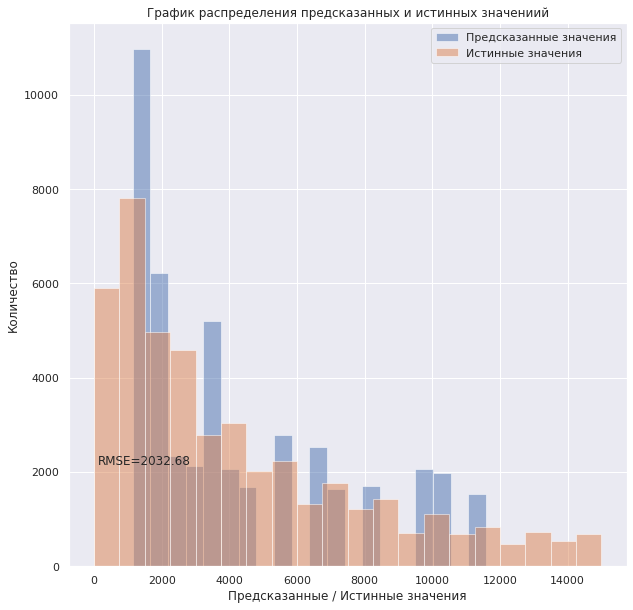

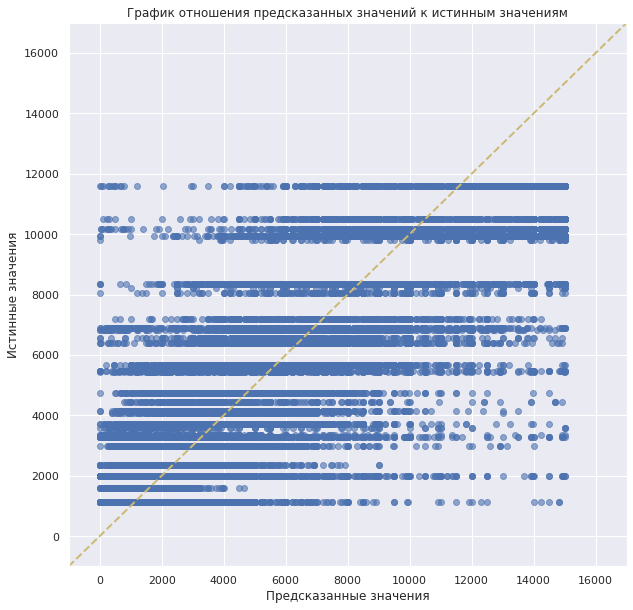

In [ ]:
plot_models_predict(target_valid_ohe, predict_DTR)

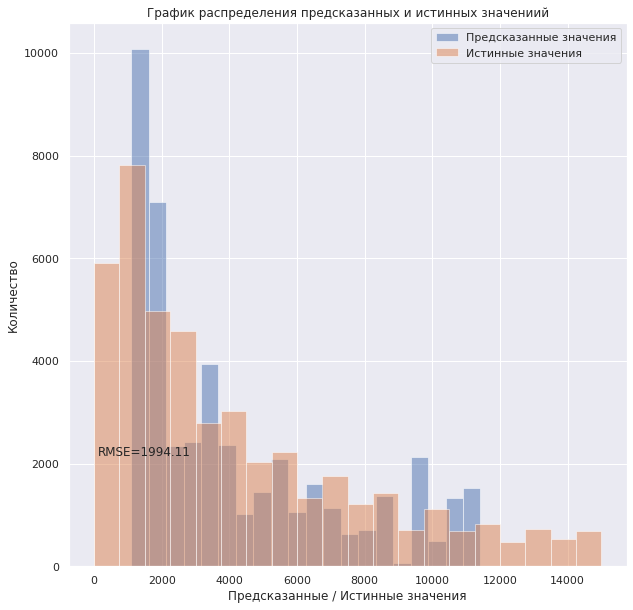

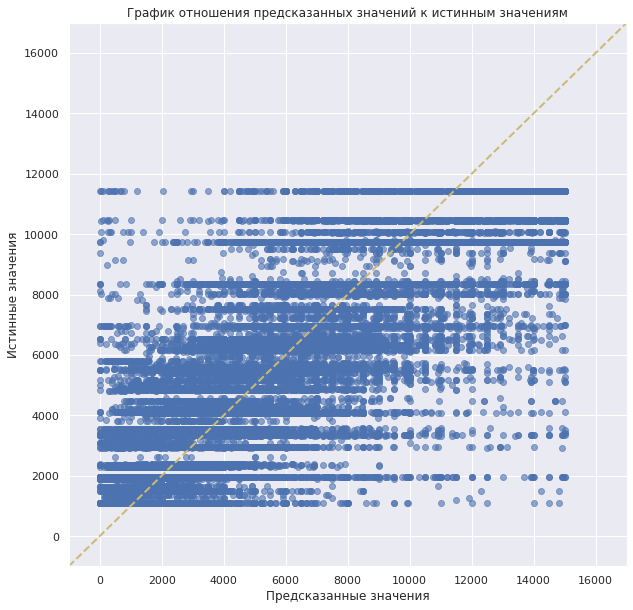

In [ ]:
plot_models_predict(target_valid_ohe, predict_RFR)

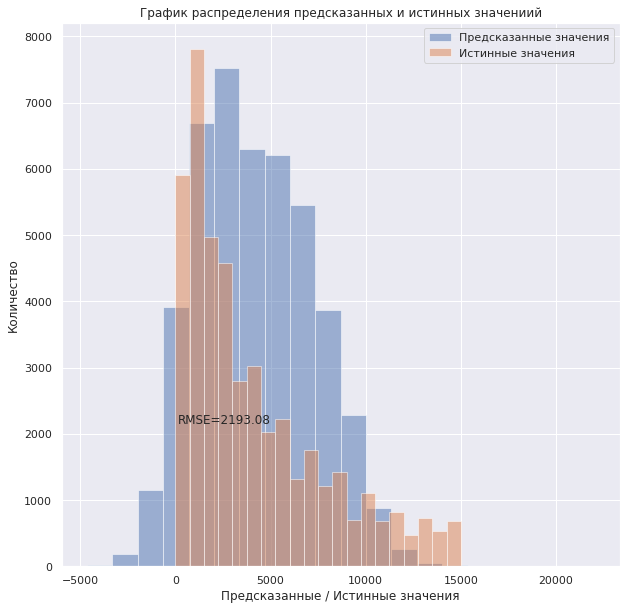

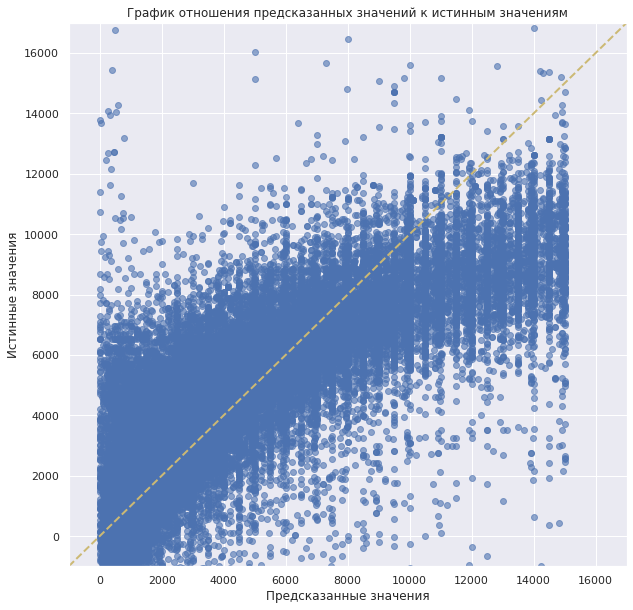

In [ ]:
plot_models_predict(target_valid_ohe, predict_LnR)

Accuracy моделей и константной модели отличаются. Это хорошо. Моедль вполне адекватна.

**Модель CatBoost**

In [ ]:
%%time
model_CtB = CatBoostRegressor(random_state=12345)
parameters = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [30, 50, 100]
              }

grid_CtB = GridSearchCV(estimator=model_CtB, param_grid = parameters, cv = 3, n_jobs=-1)
t_st = t.time()
grid_CtB.fit(features_train_oe, targets_train_oe)
t_end = t.time()


0:	learn: 3685.8509120	total: 67ms	remaining: 1.94s
1:	learn: 3662.7336868	total: 83.6ms	remaining: 1.17s
2:	learn: 3639.8846858	total: 98.7ms	remaining: 888ms
3:	learn: 3617.3055305	total: 119ms	remaining: 772ms
4:	learn: 3594.6571564	total: 133ms	remaining: 666ms
5:	learn: 3572.3267456	total: 147ms	remaining: 589ms
6:	learn: 3550.1393743	total: 161ms	remaining: 529ms
7:	learn: 3528.2590824	total: 176ms	remaining: 483ms
8:	learn: 3506.7072123	total: 190ms	remaining: 444ms
9:	learn: 3484.7156823	total: 207ms	remaining: 413ms
10:	learn: 3463.2183631	total: 223ms	remaining: 384ms
11:	learn: 3442.2190049	total: 237ms	remaining: 355ms
12:	learn: 3421.5782225	total: 251ms	remaining: 328ms
13:	learn: 3401.2697736	total: 266ms	remaining: 304ms
14:	learn: 3380.8464600	total: 280ms	remaining: 280ms
15:	learn: 3360.7344850	total: 299ms	remaining: 262ms
16:	learn: 3341.2658547	total: 315ms	remaining: 241ms
17:	learn: 3322.0526120	total: 330ms	remaining: 220ms
18:	learn: 3302.3183639	total: 345ms	

In [ ]:
t_CtB=round(t_end - t_st,2)

In [ ]:
%%time
t_st = t.time()
predict_CtB= grid_CtB.predict(features_valid_oe)
t_end = t.time()
t_CtBp=round(t_end - t_st,4)
print("Время обучения модели", t_CtB)
print("Время предсказания модели", t_CtBp)

RMSE_CtB = mean_squared_error(targets_valid_oe, predict_CtB)**0.5
print("RMSE_CtB=", RMSE_CtB)

lst.extend([RMSE_CtB, round(t_CtB,4), round(t_CtBp,4)])

Время обучения модели 191.16
Время предсказания модели 0.0212
RMSE_CtB= 1566.1281387463296
CPU times: user 25.6 ms, sys: 33 µs, total: 25.6 ms
Wall time: 23.2 ms


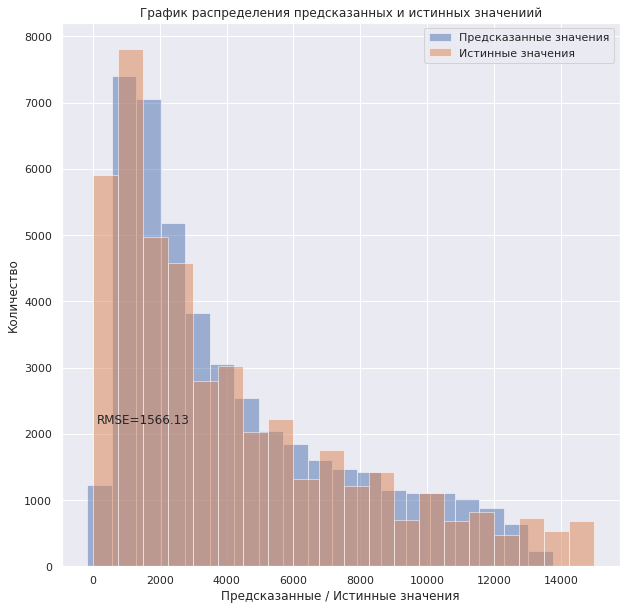

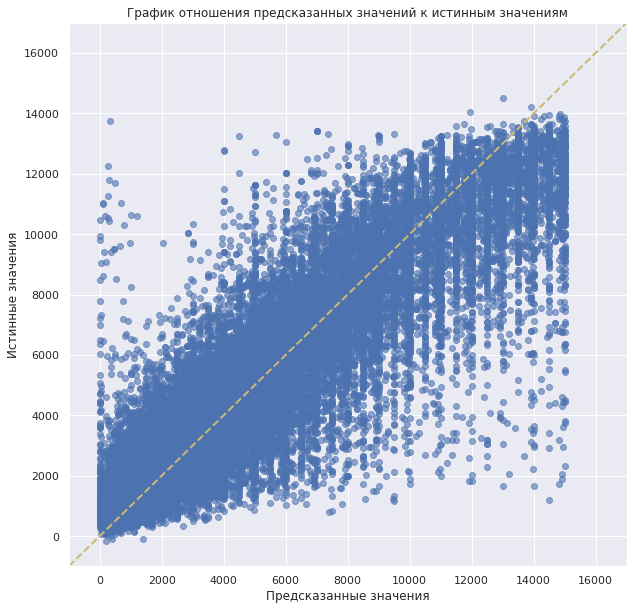

In [ ]:
plot_models_predict(targets_valid_oe, predict_CtB)

**Модель LightGBMRegressor**

In [ ]:
%%time
model_LGB = LGBMRegressor()
params = {
        'boosting_type' : ['gbdt'],
        'n_estimators' : [100],
        'max_depth' : [5, 7, 10],
        'verbose' : [100],
        'random_state' : [123],
        'num_leaves' : [100]}


grid_LGB = GridSearchCV(estimator=model_LGB, param_grid=params, cv=2, n_jobs=-1, scoring=RMSE_score)
t_st = t.time()
grid_LGB.fit(features_train_oe, targets_train_oe)
t_end = t.time()



[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.832844
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.212462
[LightGBM] [Debug] init for col-wise cost 0.199286 seconds, init for row-wise cost 0.002286 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.285484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 89647, number of used features: 8
[LightGBM] [Info] Start training from score 4191.249200
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a

In [ ]:
%%time

t_LGB=round(t_end - t_st,4)
t_st = t.time()
predict_LGB= grid_LGB.predict(features_valid_oe)
t_end = t.time()
t_LGBp=round(t_end - t_st,4)
print("Время обучения модели", t_LGB)
print("Время предсказания модели", t_LGBp)

RMSE_LGB = mean_squared_error(targets_valid_oe, predict_LGB)**0.5
print("RMSE_LGB=", RMSE_LGB)

lst.extend([RMSE_LGB, round(t_LGB,4), round(t_LGBp,4)])

Время обучения модели 1677.3284
Время предсказания модели 0.3446
RMSE_LGB= 1508.2322286053852
CPU times: user 435 ms, sys: 13.2 ms, total: 448 ms
Wall time: 347 ms


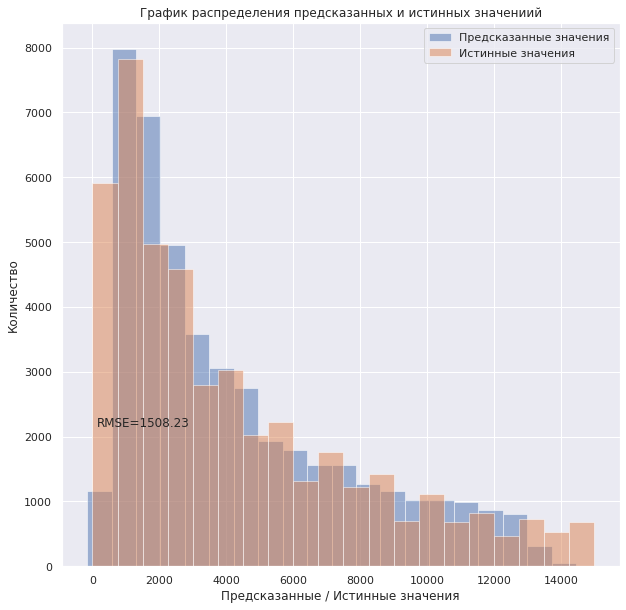

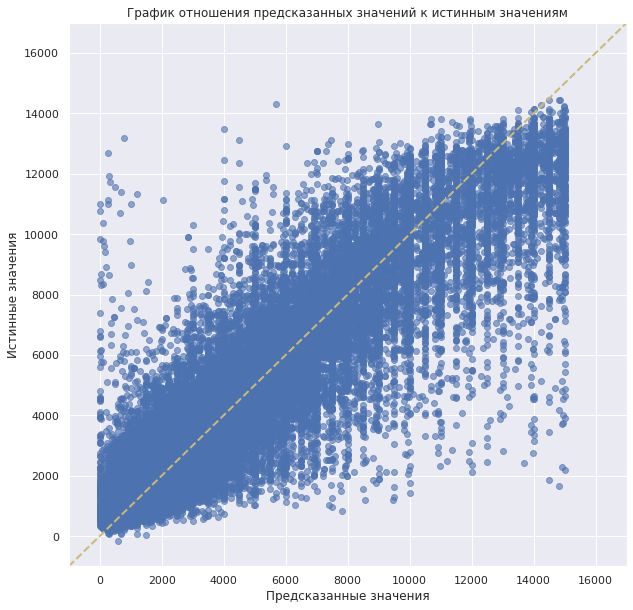

In [ ]:
plot_models_predict(targets_valid_oe, predict_LGB)

Гиперпараметры подобраны, модели обучены, оценены RMSE и время обучения и предсказания. Графики наглядно отражают насколько эти модели лучше, тех которые были в предыдущем варианте. Это действительно так.

## Анализ моделей

Проанализируем скорость работы и качество моделей.

In [ ]:
lst

[2032.6846355495575,
 27.0227,
 0.1183,
 1994.1090196148316,
 4191.2833,
 0.1023,
 2193.083305089223,
 18.6928,
 0.0129,
 1566.1281387463296,
 191.16,
 0.0212,
 1508.2322286053852,
 1677.3284,
 0.3446]

In [ ]:
column=['RMSE','Скорость обучения, s','Скорость предсказания, s']

table_metrics= pd.DataFrame(index=['RMSE','Скорость обучения, s', 'Скорость предсказания, s'], \
                            columns=['DecisionTreeRegressor', 'RandomForestRegressor','LinearRegression',\
                                     'CatBoost','LightGBM'])
table_metrics['DecisionTreeRegressor'] =  lst[0:3]
table_metrics['RandomForestRegressor'] =  lst[3:6]
table_metrics['LinearRegression'] =  lst[6:9]
table_metrics['CatBoost'] = lst[9:12]
table_metrics['LightGBM'] = lst[12:15]

table_metrics

,DecisionTreeRegressor,RandomForestRegressor,LinearRegression,CatBoost,LightGBM
RMSE,2032.684636,1994.10902,2193.083305,1566.128139,1508.232229
"Скорость обучения, s",27.022700,4191.28330,18.692800,191.160000,1677.328400
"Скорость предсказания, s",0.118300,0.10230,0.012900,0.021200,0.344600


Из таблицы видно, что все пять моделей дают приемлемый RMSE по условию задачи результат, но лучший показатель у LightGBM. Линейная регрессия - самое плохое значение, но самая быстрая по обучению. Случайный лес - по времени слишком долго.
Лучшей по RMSE показала себя LightGBM, но время ее работы также достаточно длительное. <br/><br/>
Руководствуясь требованиями заказчика, выбираем по RMSE. Самая лучшая модель по этому параметру LightGBM. <br/>

Ее значения:<br/>
- RMSE -  1508.232229
- Скорость обучения, s	- 1677.32
- Скорость предсказания, s - 0.344
    
Проверим ее на тестовой выборке.


In [ ]:
%%time

t_st = t.time()
predict_CtB= grid_CtB.predict(features_test_oe)
t_end = t.time()
t_CtBp=round(t_end - t_st,4)

print("Время предсказания на тесте", t_CtBp)

RMSE_CtB = mean_squared_error(targets_test_oe, predict_CtB)**0.5
print("RMSE_LGB=", RMSE_CtB)



Время предсказания на тесте 0.0277
RMSE_LGB= 1551.9039389061845
CPU times: user 31.8 ms, sys: 83 µs, total: 31.9 ms
Wall time: 29.9 ms


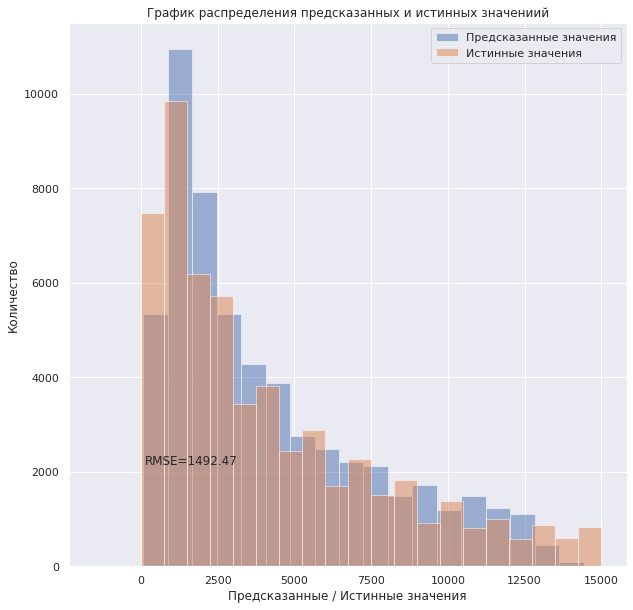

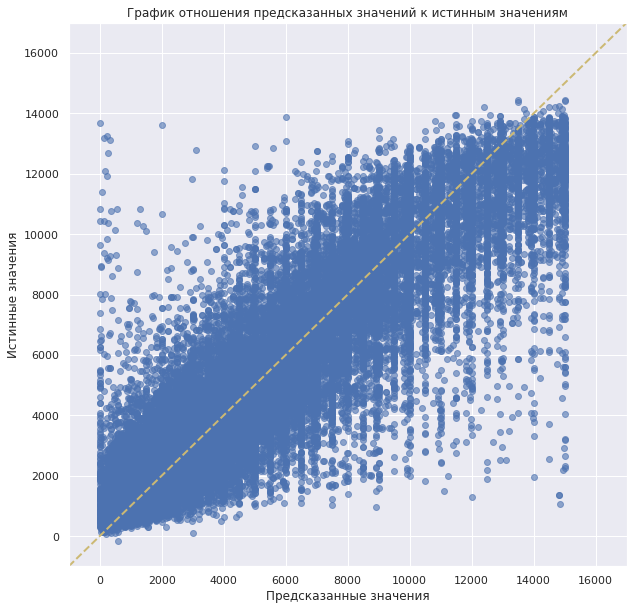

In [ ]:
plot_models_predict(targets_test_oe, predict_LGB)

**Выводы**

Проведено кодирование с использованием OHE. Обучены три модели - дерево решений, лес и линейная регрессия. Все три показали приемлемый результат. Лучший результат из трех получен на случайном лесе, но время работы этой модели слишком долгое. Но все три дали резкльтат хуже чем модели на бустинге.
    
Рассмотрены еще две модели бустинга - CatBoost, LightGBM. К ним подобраны лучшие гиперпараметры. По RMSE  лучший результат показала LightGBM, но время ее работы  достаточно длительное.
   
Модель проверена на тестовой выборке и показала близкий результат к предсказанным значениям на валидации. На графике видно, что на тесте модель хорошо справляется с предсказанием.
    
